Handling NaN in features...


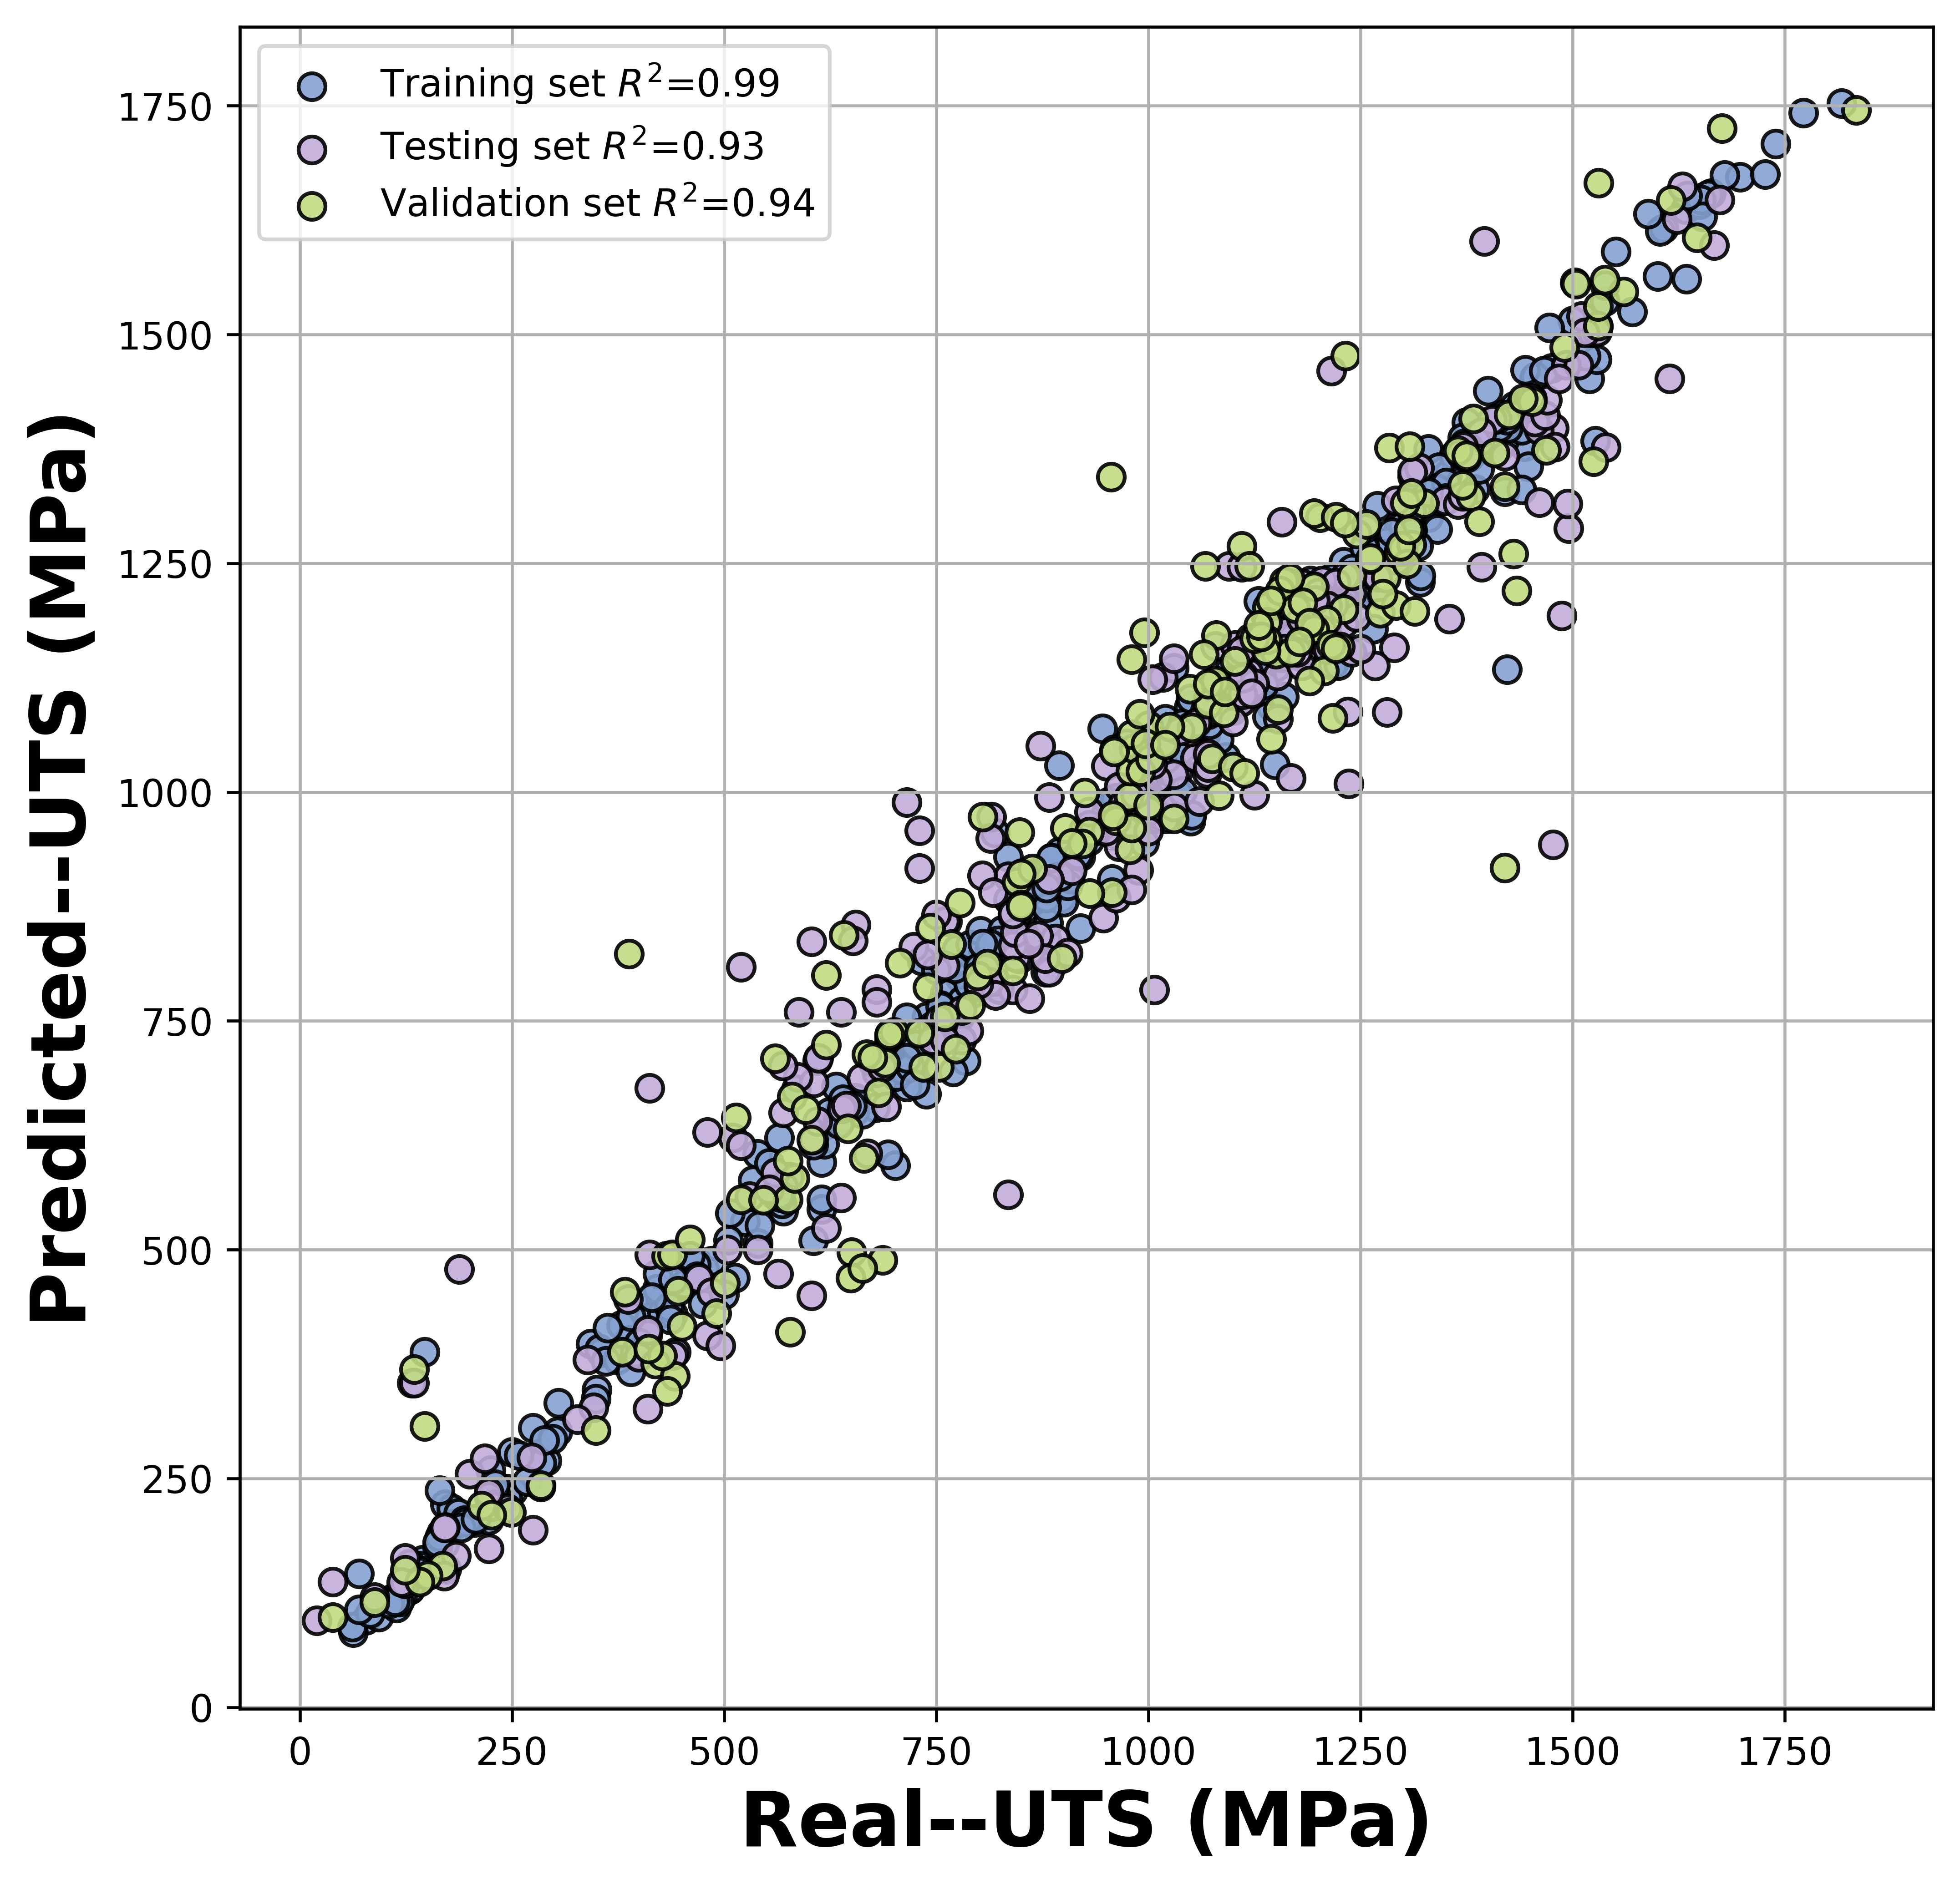

RMSE (Train): 36.64
RMSE (Test): 97.20
RMSE (Validation): 93.64
R^2 (Train): 0.99
R^2 (Test): 0.93
R^2 (Validation): 0.94


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Load the dataset
features = pd.read_excel('数据融合--高温合金数据库.xlsx')
label1 = np.array(features['UTS'])
features = features.drop(['UTS'], axis=1)

# 2. Handle NaN values in features and labels
if np.isnan(features).any().any():
    print("Handling NaN in features...")
    features.fillna(features.mean(), inplace=True)

if np.isnan(label1).any():
    print("Handling NaN in labels...")
    label1 = np.nan_to_num(label1, nan=np.nanmean(label1))

# 3. Encode categorical features
features = pd.get_dummies(features)
feature_list = list(features.columns)
features = np.array(features)

# 4. Normalize the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Ensure no NaN or Inf values after scaling
if np.isnan(features).any() or np.isinf(features).any():
    print("Detected NaN or Inf in features after scaling. Fixing them...")
    features = np.nan_to_num(features)

# 5. Split the dataset into training, validation, and testing sets
test_ratio = 0.25
validation_ratio = 0.2  # 20% of the data for validation
SEED = 26

# Split into train and temporary sets
train_features, temp_features, train_labels, temp_labels = train_test_split(features, label1,
                                                                            test_size=(test_ratio + validation_ratio),
                                                                            random_state=SEED)
# Split temporary set into test and validation sets
test_features, validation_features, test_labels, validation_labels = train_test_split(temp_features, temp_labels,
                                                                                      test_size=validation_ratio / (test_ratio + validation_ratio),
                                                                                      random_state=SEED)

# 6. Train a Random Forest Regressor
model_rf = RandomForestRegressor(random_state=100)
model_rf.fit(train_features, train_labels)

# 7. Make predictions
train_predicted_UTS = model_rf.predict(train_features)
test_predicted_UTS = model_rf.predict(test_features)
validation_predicted_UTS = model_rf.predict(validation_features)

# 8. Compute performance metrics
rmse_tr_rf = mean_squared_error(train_labels, train_predicted_UTS, squared=False)
rmse_te_rf = mean_squared_error(test_labels, test_predicted_UTS, squared=False)
rmse_val_rf = mean_squared_error(validation_labels, validation_predicted_UTS, squared=False)
r2_tr_rf = r2_score(train_labels, train_predicted_UTS)
r2_te_rf = r2_score(test_labels, test_predicted_UTS)
r2_val_rf = r2_score(validation_labels, validation_predicted_UTS)

# 9. Plot results
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.dpi'] = 600

ax = plt.axes()
ax.set_facecolor("white")
plt.grid()
plt.scatter(train_labels, train_predicted_UTS, alpha=0.9, s=50, linewidths=1.0, c='#85a2d2',
            edgecolor='#000000', label='Training set' + ' ' + '$R^2$=%.2f' % r2_tr_rf, marker='o')
plt.scatter(test_labels, test_predicted_UTS, alpha=0.9, s=50, linewidths=1.0, c='#c2acda',
            edgecolor='#000000', label='Testing set' + ' ' + '$R^2$=%.2f' % r2_te_rf, marker='o')
plt.scatter(validation_labels, validation_predicted_UTS, alpha=0.9, s=50, linewidths=1.0, c='#c0db82',
            edgecolor='#000000', label='Validation set' + ' ' + '$R^2$=%.2f' % r2_val_rf, marker='o')

plt.xlabel('Real--UTS (MPa)', size=20, weight='bold')
plt.ylabel('Predicted--UTS (MPa)', size=20, weight='bold')
plt.legend()
plt.show()

# 10. Display performance metrics
print("RMSE (Train): {:.2f}".format(rmse_tr_rf))
print("RMSE (Test): {:.2f}".format(rmse_te_rf))
print("RMSE (Validation): {:.2f}".format(rmse_val_rf))
print("R^2 (Train): {:.2f}".format(r2_tr_rf))
print("R^2 (Test): {:.2f}".format(r2_te_rf))
print("R^2 (Validation): {:.2f}".format(r2_val_rf))

In [4]:
# 读取初始数据
initial_data = pd.read_excel('初始.xlsx')
initial_data = initial_data.drop(['UTS','总应变幅','弹性应变幅','塑形应变幅','FS'], axis=1)
# 对初始数据进行独热编码
initial_data_encoded = pd.get_dummies(initial_data)

# 确保列顺序与训练时一致
for col in feature_list:
    if col not in initial_data_encoded.columns:
        initial_data_encoded[col] = 0
initial_data_encoded = initial_data_encoded[feature_list]

# 对初始数据进行归一化处理
initial_data_scaled = MinMaxScaler().fit_transform(initial_data_encoded)

# 进行预测
predicted_UTS = model_rf.predict(initial_data_scaled)

# 将预测值添加到初始数据
initial_data['Predicted_UTS'] = predicted_UTS

# 保存到新表格
initial_data.to_excel('预测结果.xlsx', index=False)

print("预测结果已保存到 '预测结果.xlsx'")

预测结果已保存到 '预测结果.xlsx'


In [6]:
import pandas as pd
import numpy as np

# 读取预测结果表格
data = pd.read_excel('预测结果.xlsx')

# 转换真实值和预测值为数值类型
data['UTS'] = pd.to_numeric(data['UTS'], errors='coerce')
data['Predicted_UTS'] = pd.to_numeric(data['Predicted_UTS'], errors='coerce')

# 去除包含 NaN 的行
data = data.dropna(subset=['UTS', 'Predicted_UTS'])

# 获取真实值和预测值
true_values = data['UTS']
predicted_values = data['Predicted_UTS']

# 计算每个样本的MAPE
mape_values = np.abs((true_values - predicted_values) / true_values) * 100

# 添加MAPE列到数据表中
data['MAPE'] = mape_values

# 根据阈值分组
threshold = 3.0  # 阈值为3%
above_threshold_data = data[mape_values > threshold]
below_threshold_data = data[mape_values <= threshold]

# 保存到Excel文件中
above_threshold_data.to_excel('阈值大于3%的样本.xlsx', index=False)
below_threshold_data.to_excel('阈值小于等于3%的样本.xlsx', index=False)

# 输出确认
print(f"阈值 > 3% 的样本数量: {above_threshold_data.shape[0]}")
print(f"阈值 <= 3% 的样本数量: {below_threshold_data.shape[0]}")


阈值 > 3% 的样本数量: 371
阈值 <= 3% 的样本数量: 250


In [8]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. Load both failed and successful datasets
# Load source domain data (failed data)
source_data = pd.read_excel('阈值大于3%的样本的副本.xlsx')

# Load target domain data (successful data)
successful_data = pd.read_excel('阈值小于等于3%的样本的副本.xlsx')

# Check and handle NaN values
if source_data.isna().any().any():
    print("Handling NaN in source data...")
    source_data.fillna(source_data.mean(), inplace=True)

if successful_data.isna().any().any():
    print("Handling NaN in successful data...")
    successful_data.fillna(successful_data.mean(), inplace=True)

# 2. Define alloy components and their ranges
elements = ["Ni", "Cr", "Co", "Fe", "Al", "Ti", "Nb", "Mo", "W"]
min_values = [50, 0, 0, 0, 0, 0, 0, 1.5, 0]
max_values = [75, 21, 20, 20, 3.5, 4.5, 5.5, 7.5, 8]

# Ensure that both datasets have the necessary columns
required_columns = elements + ['FS']
if not all(col in source_data.columns for col in required_columns):
    raise ValueError("Source data is missing required columns.")
if not all(col in successful_data.columns for col in required_columns):
    raise ValueError("Successful data is missing required columns.")

# 3. Preprocess the data (scaling)
scaler = MinMaxScaler()
successful_data_scaled = scaler.fit_transform(successful_data[elements])

# 4. Train the GMM on successful data
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(successful_data_scaled)

# 5. Define the GMM-based loss function
def gmm_loss_function(components, gmm, scaler):
    """
    Loss function to minimize the negative log likelihood of the components under the GMM.

    Parameters:
    - components: Alloy components (optimization variables).
    - gmm: Trained GMM model.
    - scaler: Scaler object for normalization.

    Returns:
    - Negative log likelihood.
    """
    components = np.array(components).reshape(1, -1)
    scaled_components = scaler.transform(components)  # Normalize
    log_likelihood = gmm.score(scaled_components)  # GMM log likelihood
    return -log_likelihood  # Minimize negative log likelihood

# 6. Optimization process
optimized_results = []

for idx, row in source_data.iterrows():
    # Initial components from failed data
    initial_components = row[elements].values

    # Define boundary conditions
    bounds = list(zip(min_values, max_values))

    # Optimize using GMM-based optimization
    result = minimize(
        gmm_loss_function,
        initial_components,
        args=(gmm, scaler),
        method='L-BFGS-B',
        bounds=bounds
    )

    # Check if optimization was successful
    if result.success:
        optimized_components = result.x
        optimized_loss = result.fun
    else:
        optimized_components = initial_components
        optimized_loss = np.nan
        print(f"Optimization failed for sample index {idx}: {result.message}")

    # Save optimization results
    optimized_results.append({
        'Sample_Index': idx,
        **{f'Optimized_{col}': val for col, val in zip(elements, optimized_components)},
        'Optimized_Loss': optimized_loss
    })

# 7. Convert optimization results to DataFrame
optimized_df = pd.DataFrame(optimized_results)

# 8. Save results to Excel
output_path = '目标域合金优化结果_GMM.xlsx'
optimized_df.to_excel(output_path, index=False)

print(f"Optimization completed. Results saved to {output_path}")

Handling NaN in source data...
Optimization completed. Results saved to 目标域合金优化结果_GMM.xlsx
